In [1]:
# --- Data manipulation ---
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize

# --- Data visualization ---
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
#     """We are only concerned with analysing the primary market for our project, 
#     therefore we must remove all rows associated with the action loan purchased by the instituiton. 
#     We also need to remove all rows associated with the action 'Application withdrawn by client"""

# Washington State HDMA 2016

In [2]:
file = "raw_data/Washington_State_HDMA-2016.csv"
data_original = pd.read_csv(file, decimal=',')

In [3]:
def clean_data(data: pd.DataFrame):
    # Define list of columns to filter for "Information not provided" values
    filter_cols = ['applicant_ethnicity_name', 'applicant_race_name_1', 'applicant_sex_name',
                   'co_applicant_ethnicity_name', 'co_applicant_race_name_1', 'co_applicant_sex_name']
    
    # Filter for rows where "action_taken_name" is not equal to certain values
    data = data.loc[~data['action_taken_name'].isin(['Application withdrawn by applicant', 'Loan purchased by the institution', 'File closed for incompleteness'])]
    
    # Filter for rows where values in specified columns are not equal to "Information not provided"
    for col in filter_cols:
        data = data.loc[~data[col].isin(['Information not provided by applicant in mail, Internet, or telephone application'])]
        
    # Drop rows with missing values in "county_name" column
    data = data.dropna(subset=['county_name'])
    
    # Create new column "loan_status" based on "action_taken_name"
    data['loan_status'] = np.where(data['action_taken_name'] == 'Loan originated', 'approved', 'not approved')
    
    # Drop irrelevant columns
    drop_cols = ['applicant_race_name_5', 'applicant_race_name_4', 'applicant_race_name_3',
                 'applicant_race_name_2', 'co_applicant_race_name_5', 'co_applicant_race_name_4',
                 'co_applicant_race_name_3', 'co_applicant_race_name_2', 'denial_reason_name_3',
                 'denial_reason_name_2', 'denial_reason_name_1', 'rate_spread', 'edit_status_name',
                 'state_abbr', 'respondent_id', 'agency_abbr', 'as_of_year', 'application_date_indicator',
                 'state_name', 'sequence_number', 'census_tract_number']
    data = data.drop(columns=drop_cols)
    
    # Winsorize numeric columns
    data.select_dtypes(exclude=['object']).apply(lambda x: winsorize(x, limits=[0.05, 0.05]), axis=0, raw=True)
        
    return data

In [4]:
data = clean_data(data_original)
data.head(2)

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,purchaser_type_name,property_type_name,...,county_name,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_name,action_taken_name,loan_status
1,83.37000275,4915.0,23.98999977,1268.0,1777.0,240,57900.0,42.0,"Life insurance company, credit union, mortgage...",One-to-four family dwelling (other than manufa...,...,Walla Walla County,No co-applicant,No co-applicant,No co-applicant,Male,White,Hispanic or Latino,Department of Housing and Urban Development,Loan originated,approved
2,91.12999725,5075.0,11.81999969,1136.0,1838.0,241,73300.0,117.0,Loan was not originated or was not sold in cal...,One-to-four family dwelling (other than manufa...,...,Clark County,Female,White,Not Hispanic or Latino,Male,White,Not Hispanic or Latino,Department of Housing and Urban Development,Loan originated,approved


In [5]:
data['tract_to_msamd_income'] = data['tract_to_msamd_income'].astype(float)
data['minority_population'] = data['minority_population'].astype(float)

## Visualization

In [6]:
def percent_stacked_bar(index,col,kind='bar',figsize=(5, 5),fontsize=7,colormap='Spectral',loc="best"):
    cross_tab = pd.crosstab(index=index,columns=col)
    cross_tab_percent = pd.crosstab(index=index,columns=col,normalize="index")
    
    cross_tab_percent.plot(kind=kind,stacked=True,colormap=colormap,figsize=figsize)

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_loc) in zip(cross_tab_percent.loc[x],
                                              cross_tab.loc[x],
                                              cross_tab_percent.loc[x].cumsum()):
            
            if kind =='barh':
                y=n - 0.17
                x=(y_loc - proportion) + (proportion / 2)
            else:
                x=n - 0.17
                y=(y_loc - proportion) + (proportion / 2)
            plt.text(x=x,
                     y=y,
                     s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                     color="white",
                     fontsize=fontsize,
                     fontweight="bold")
                
    plt.show()

### Variables Affecting Loan Status

approved        78.38
not approved    21.62
Name: loan_status, dtype: float64


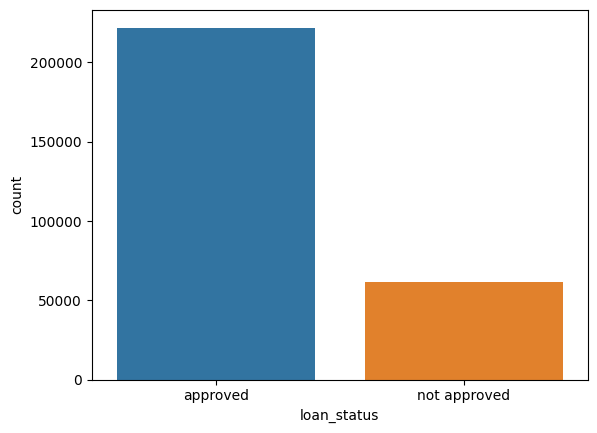

In [7]:
sns.countplot(data, x=data['loan_status']);

print(round(data['loan_status'].value_counts(normalize=True)*100,2))

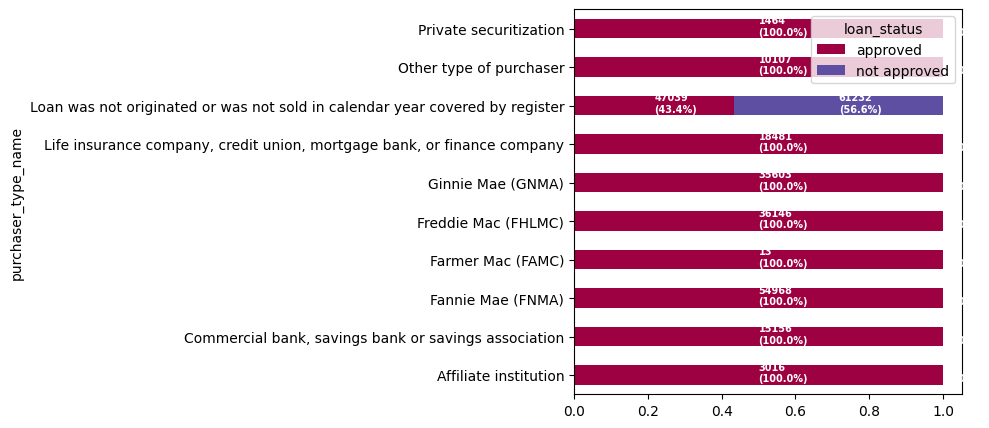

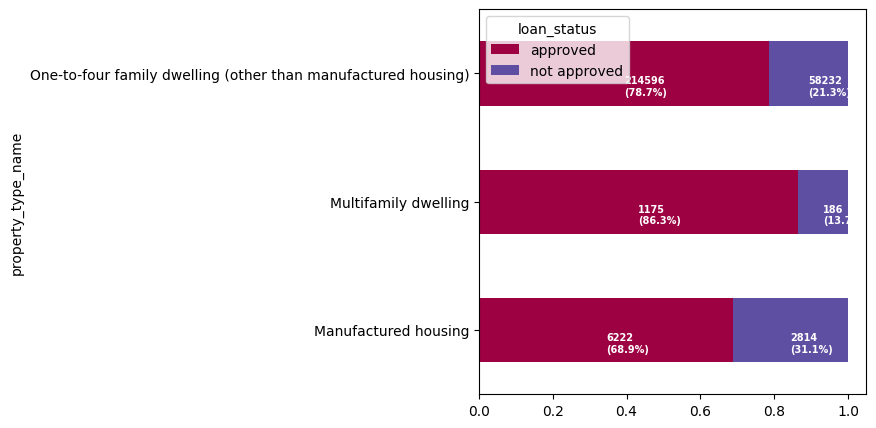

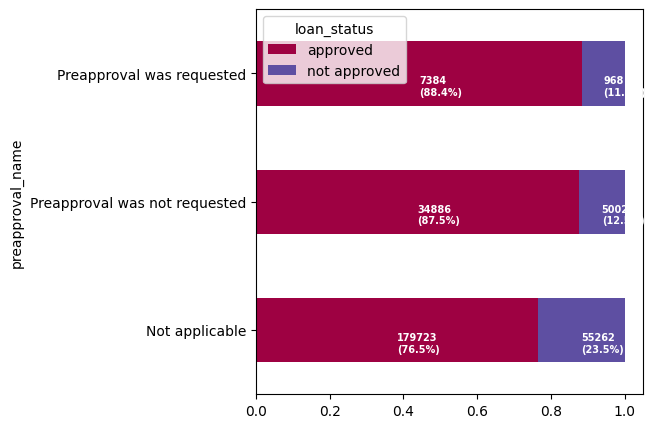

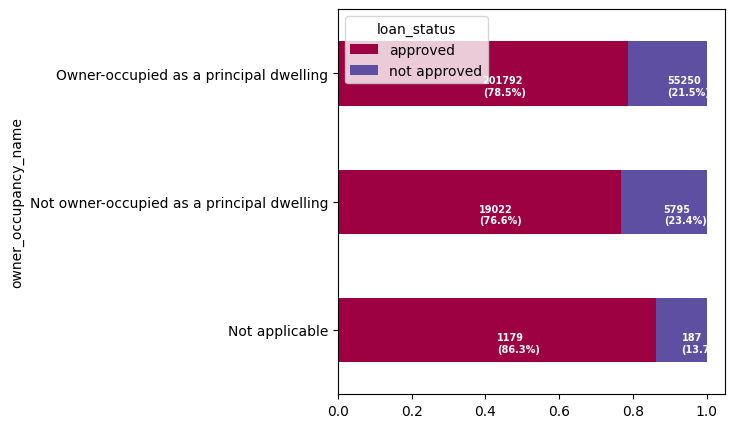

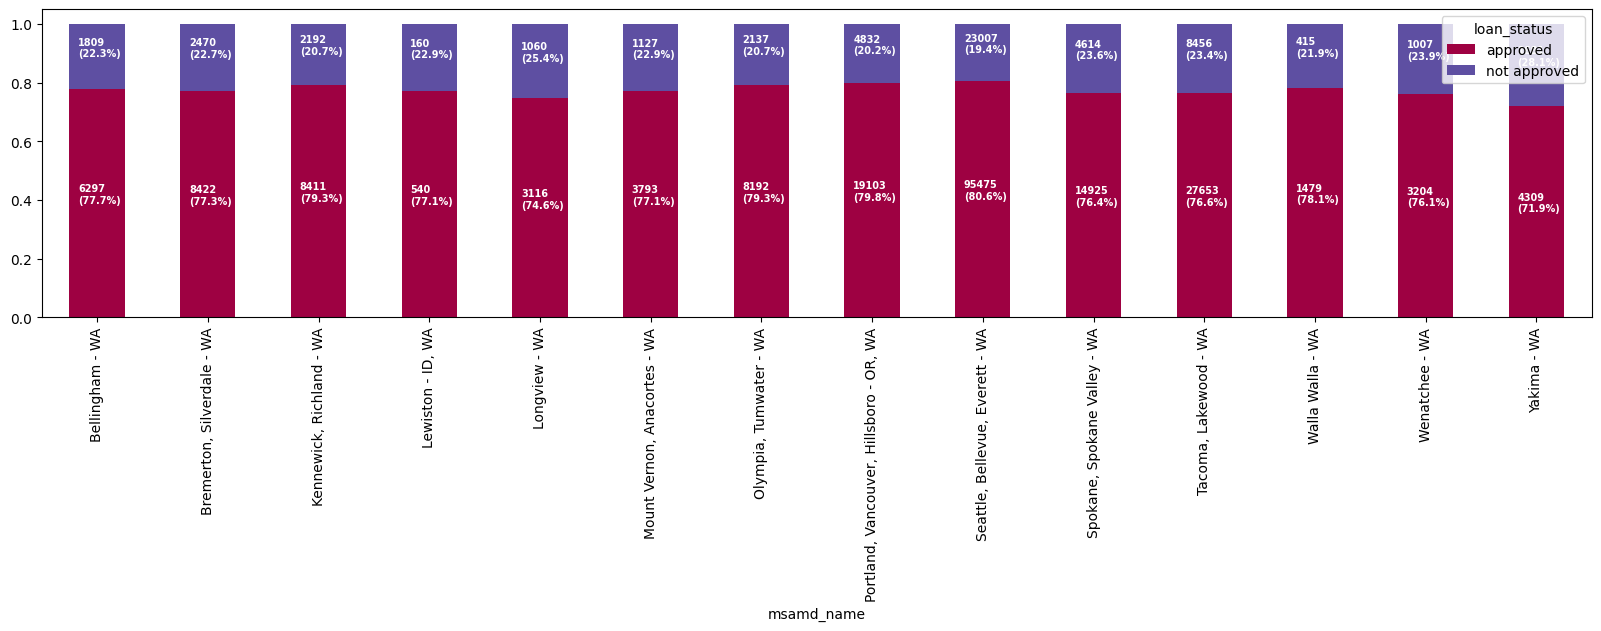

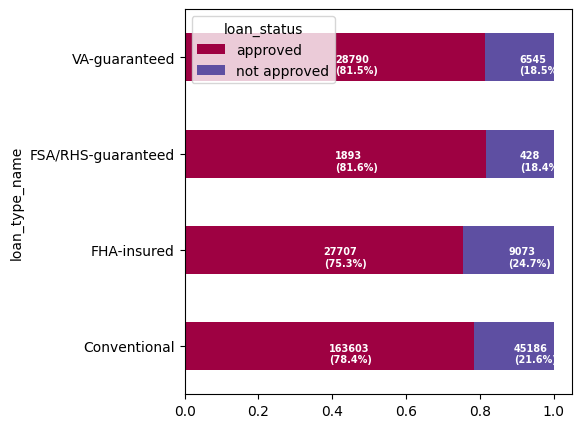

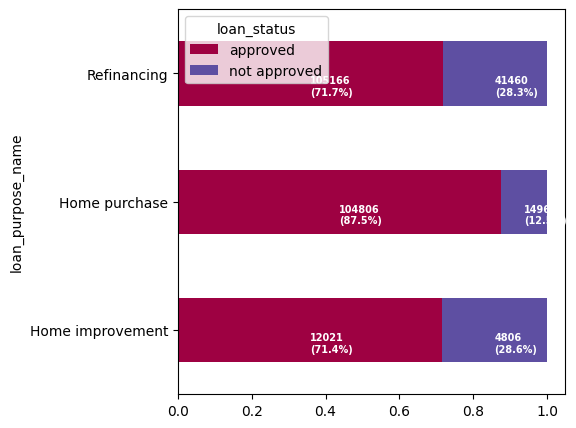

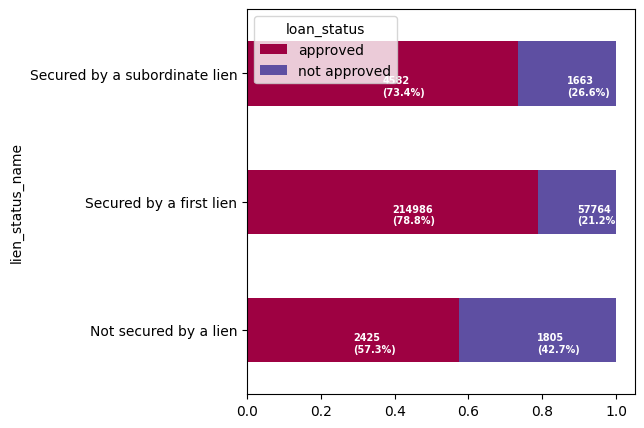

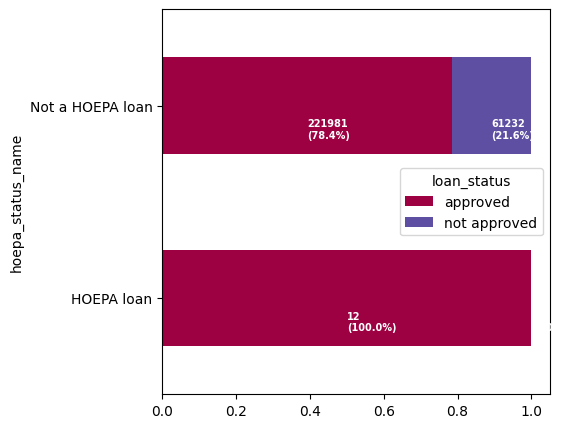

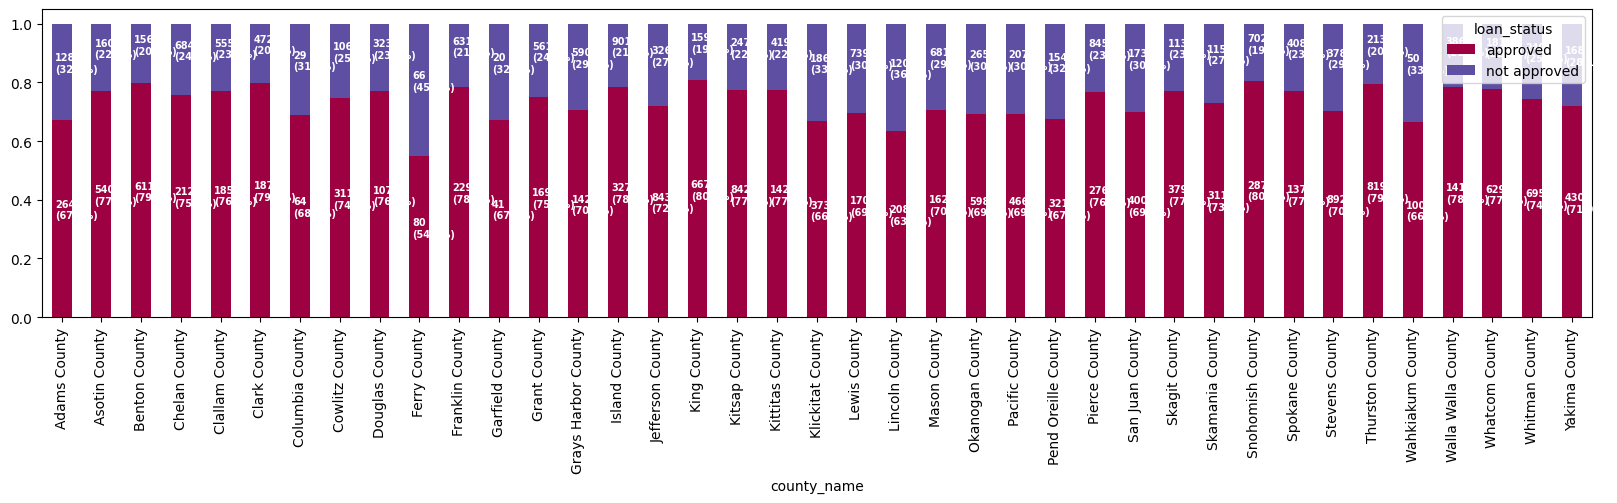

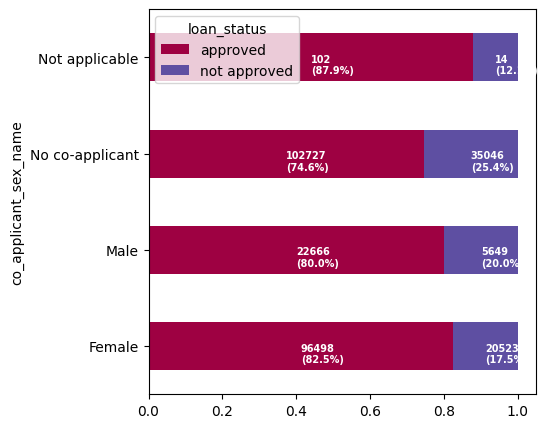

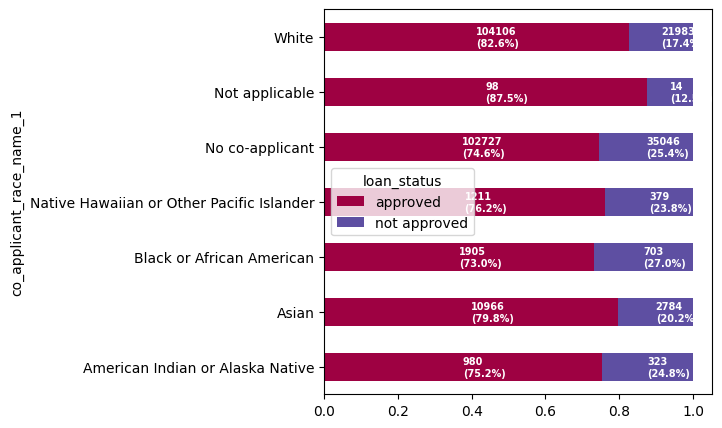

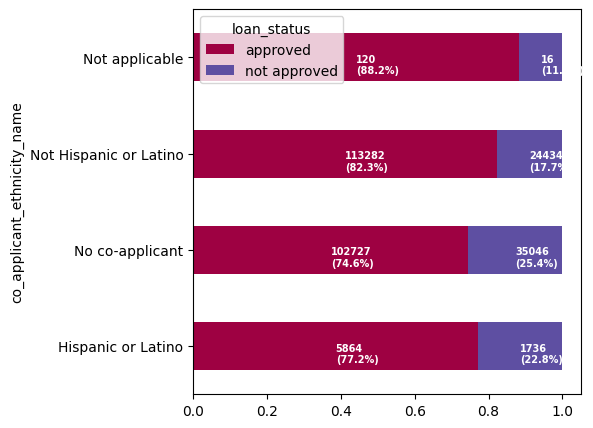

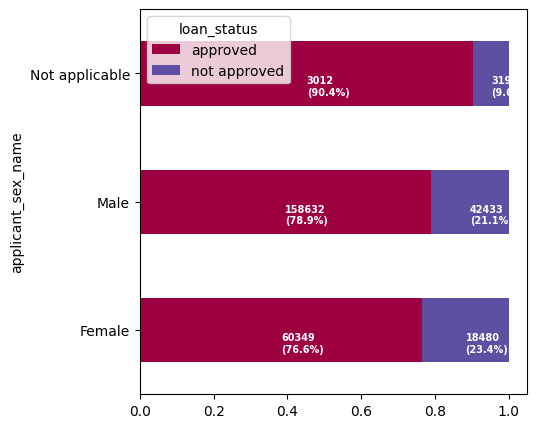

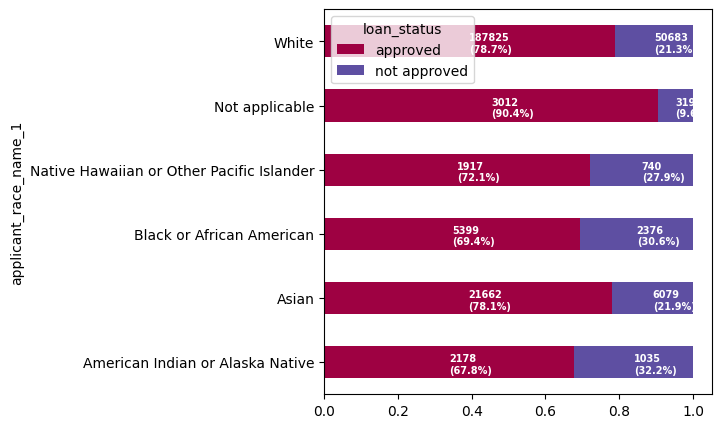

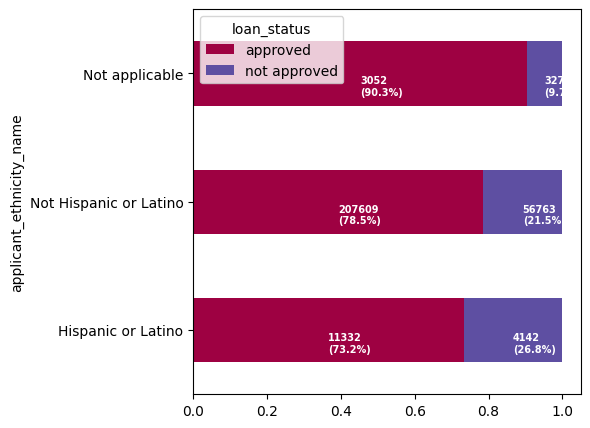

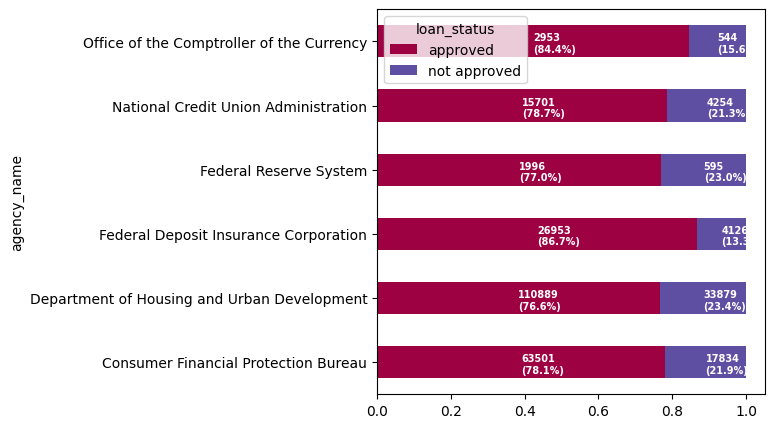

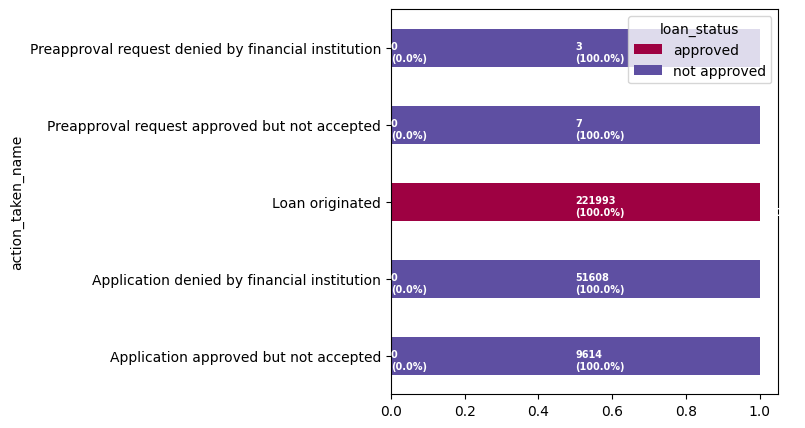

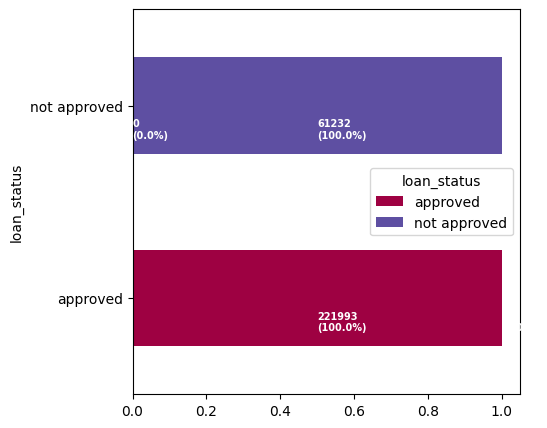

In [8]:
df_object = data.dtypes[data.dtypes=="object"]
col_object = df_object.index
for i in col_object:
    if data[i].nunique() > 10:
        percent_stacked_bar(index = data[i],col =data['loan_status'],kind='bar',figsize=(20, 4))
    else:
        percent_stacked_bar(index = data[i],col =data['loan_status'],kind='barh')

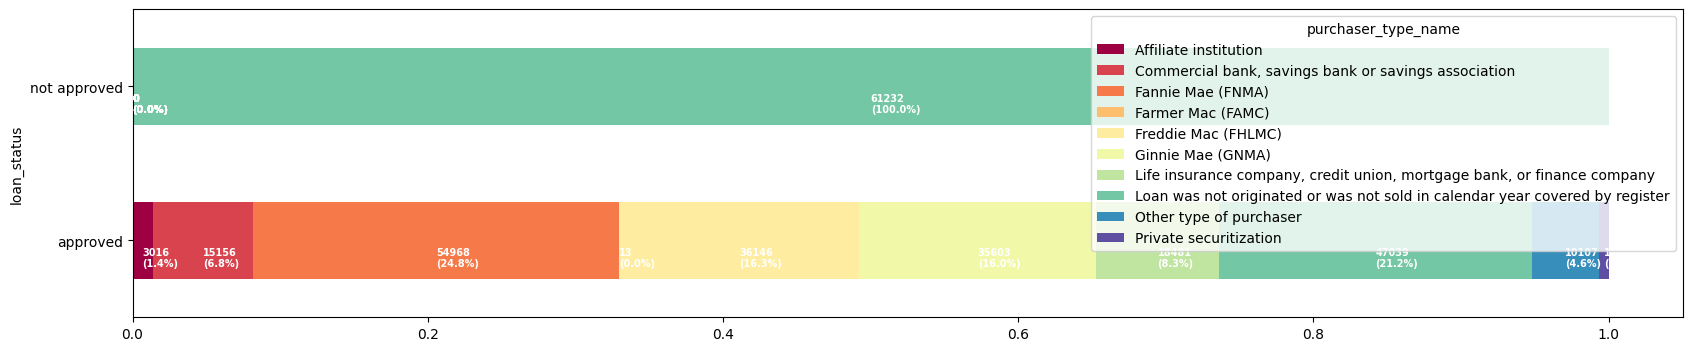

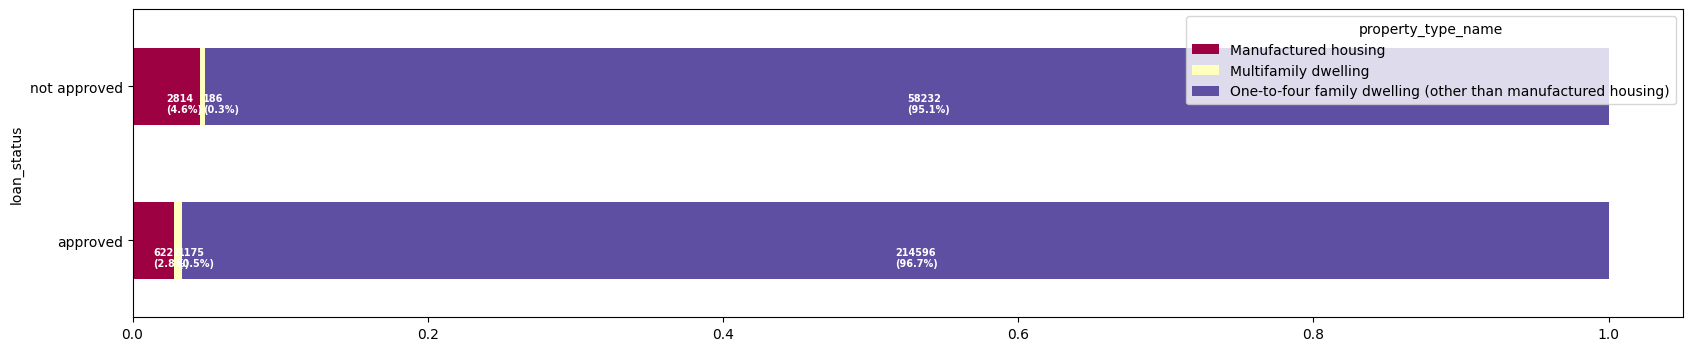

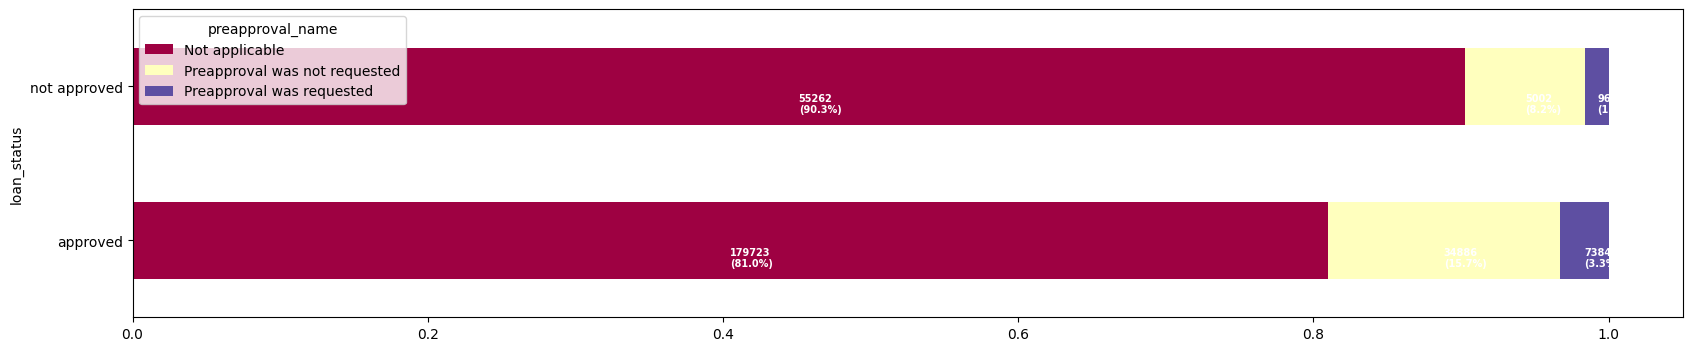

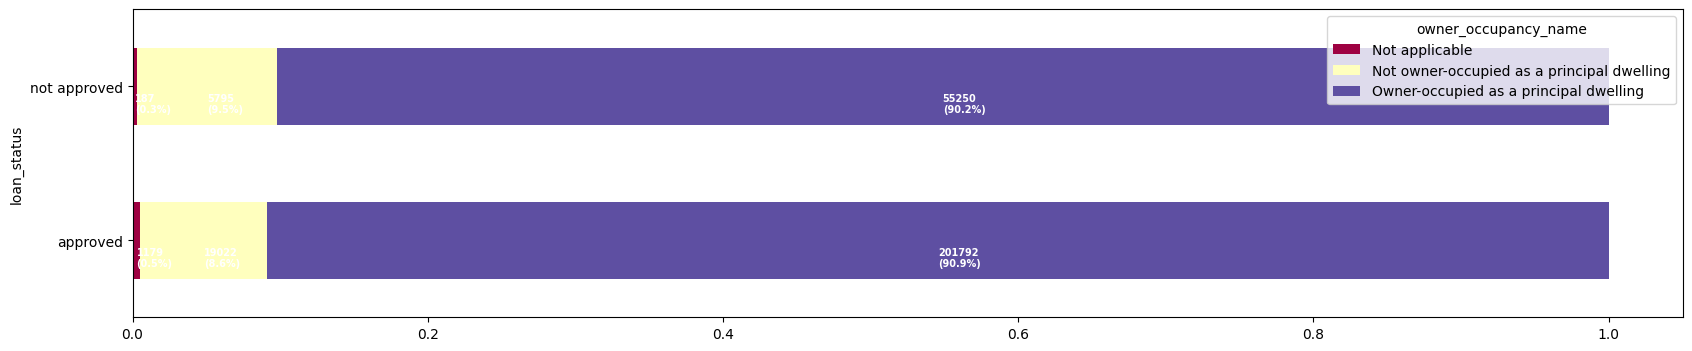

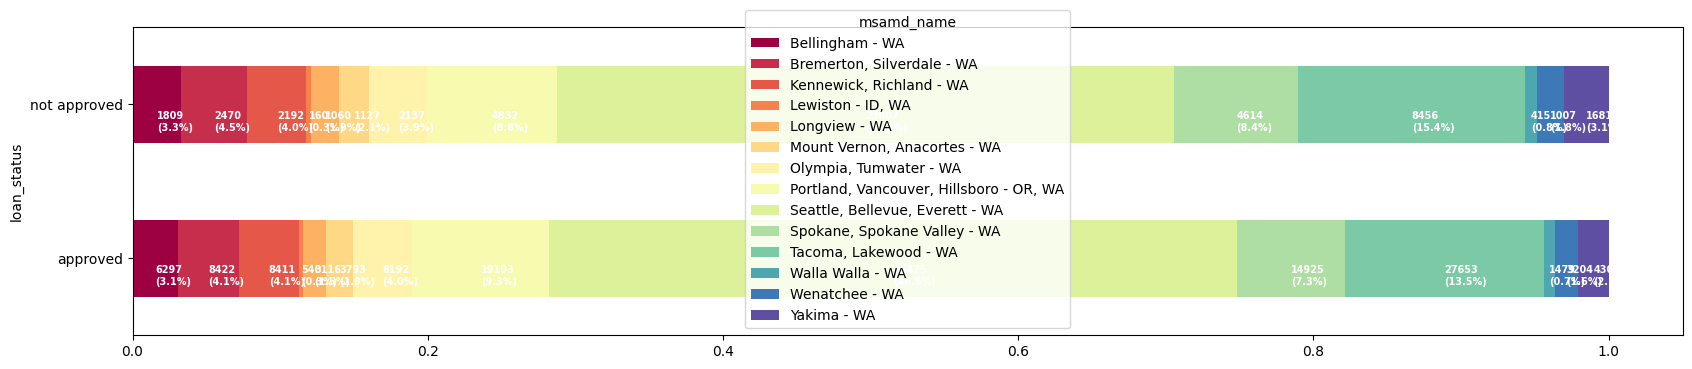

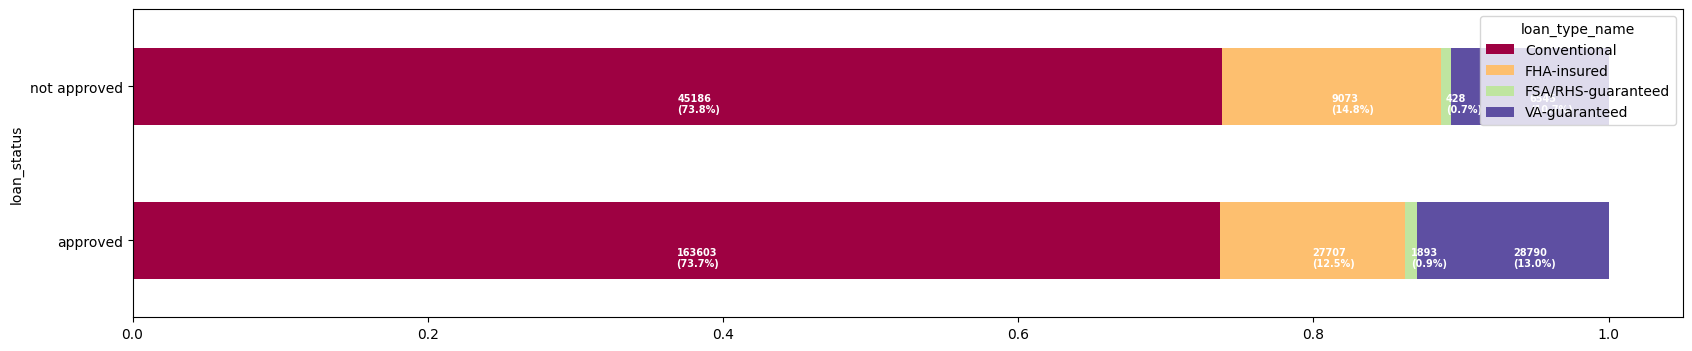

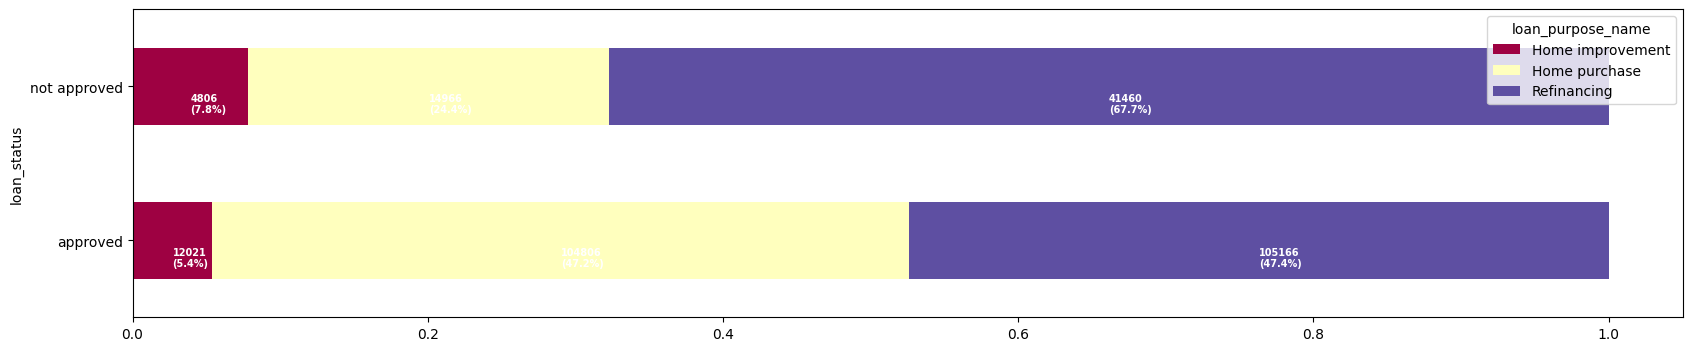

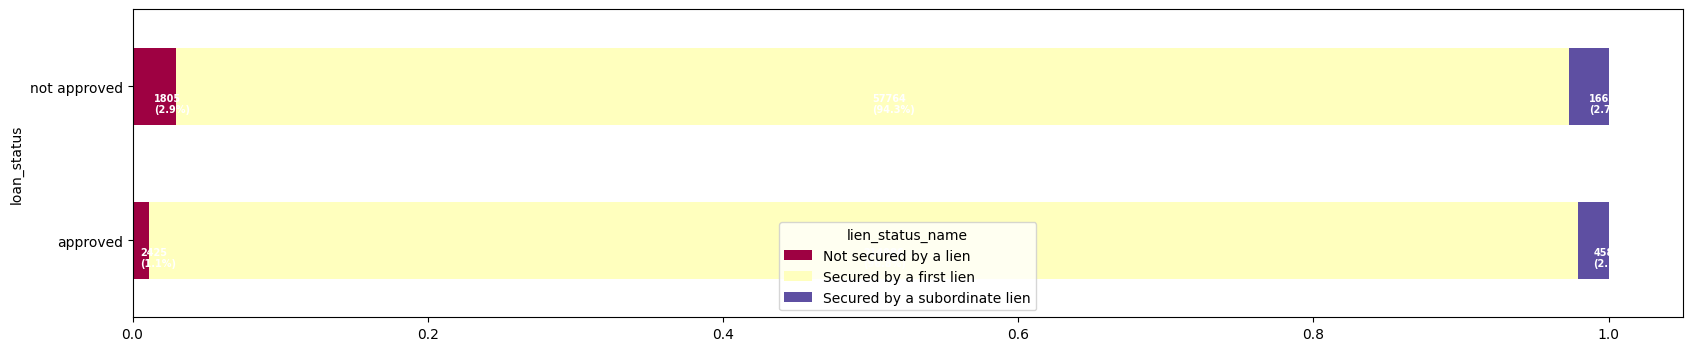

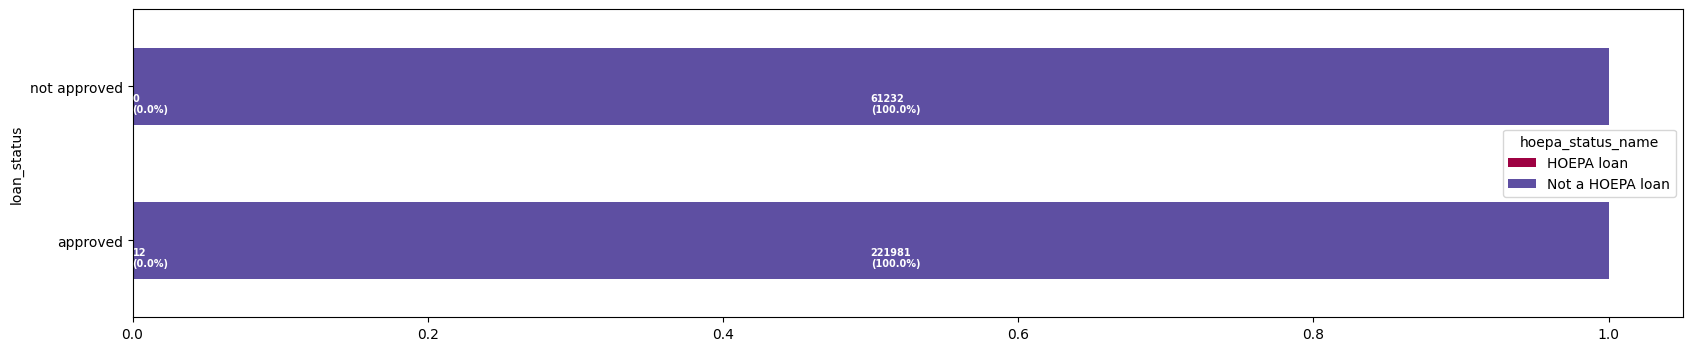

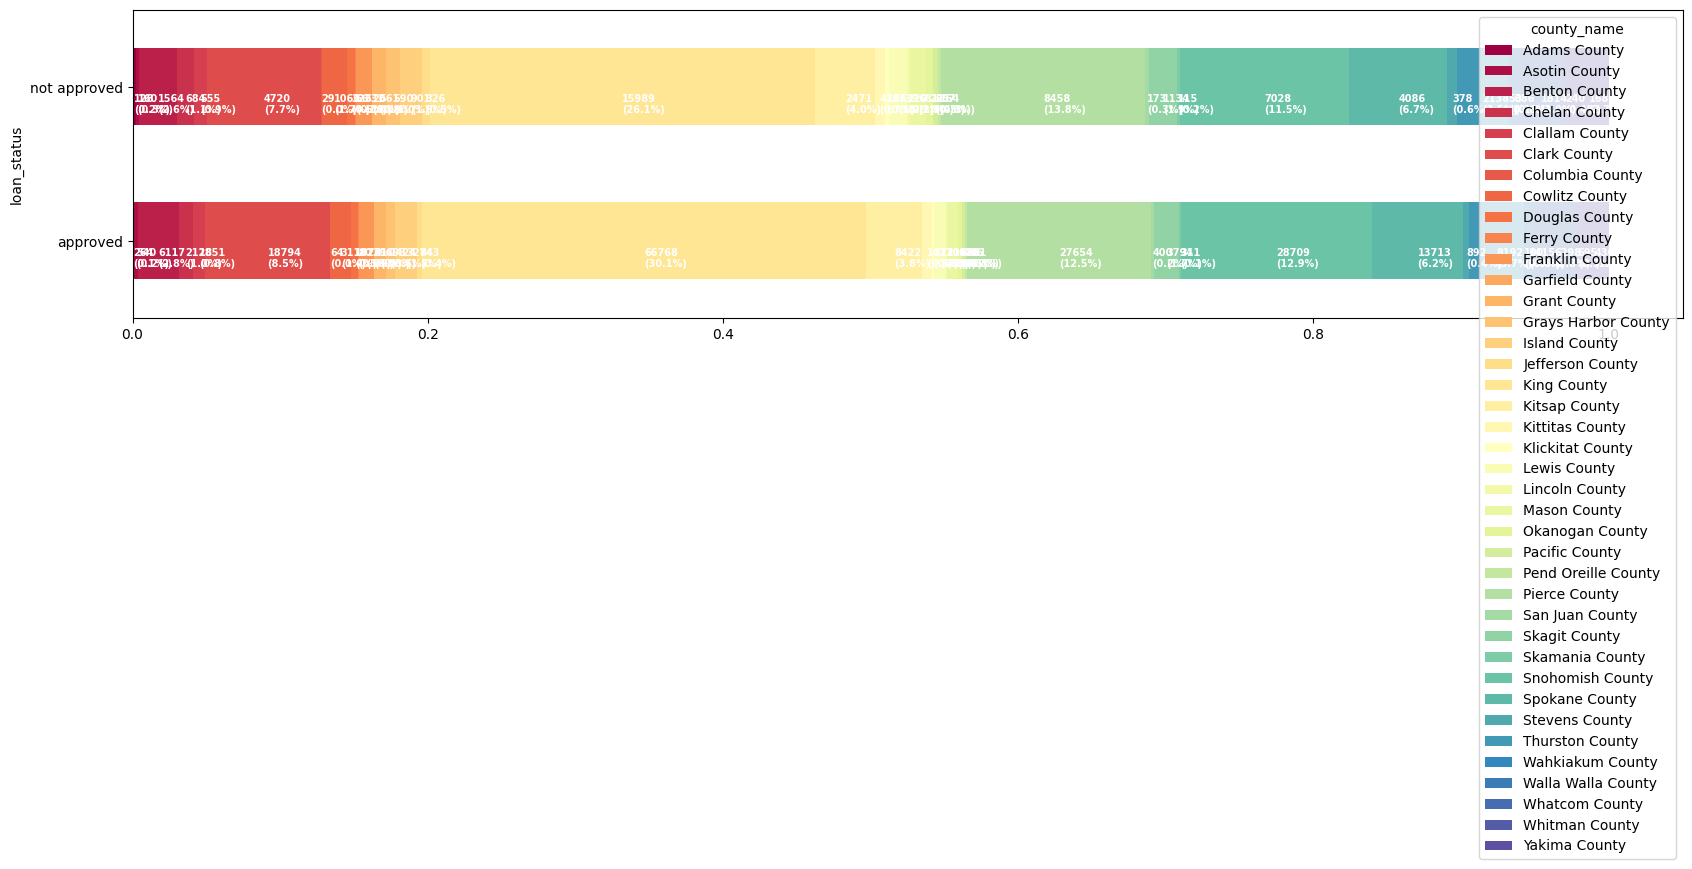

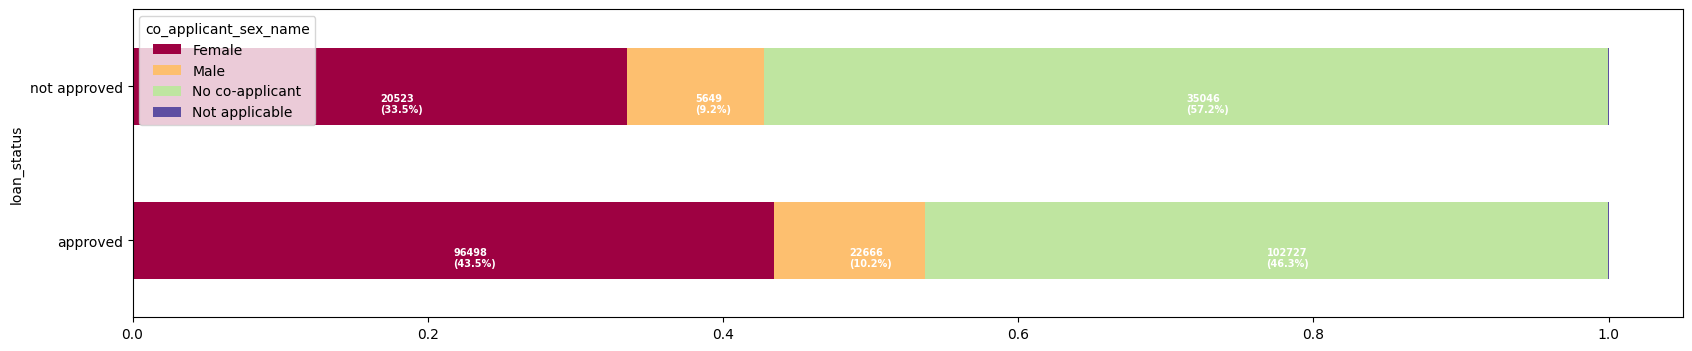

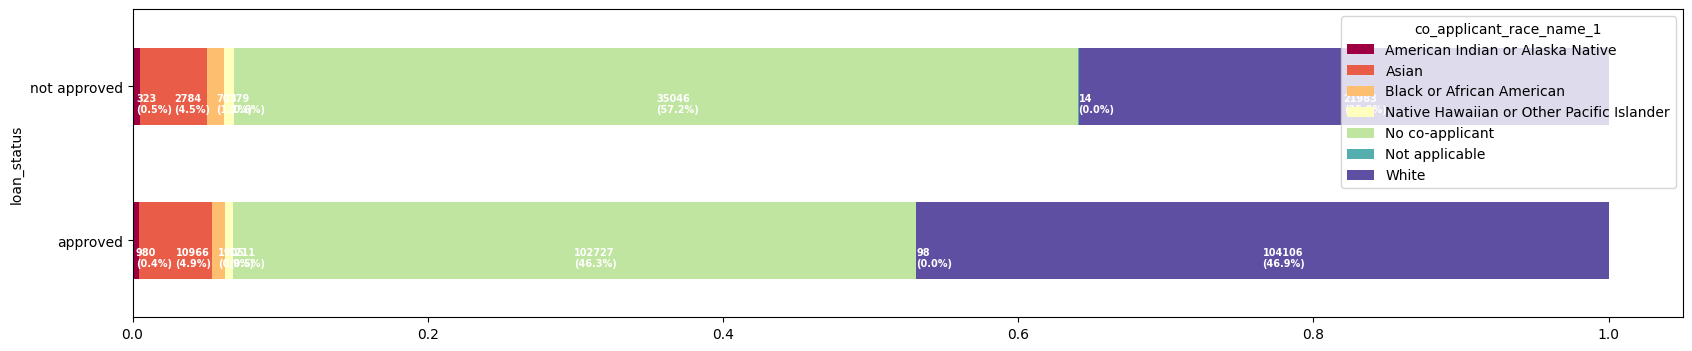

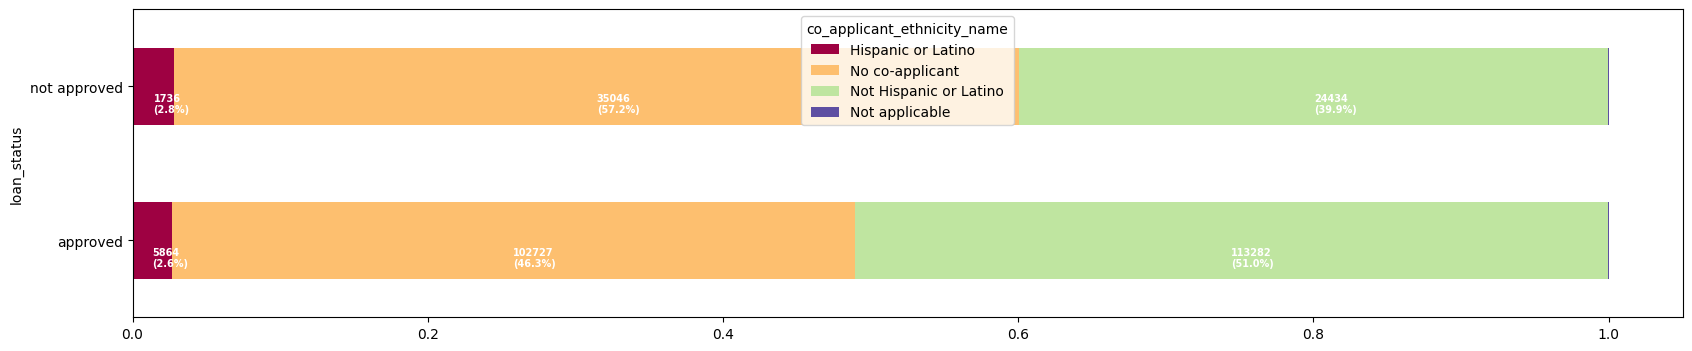

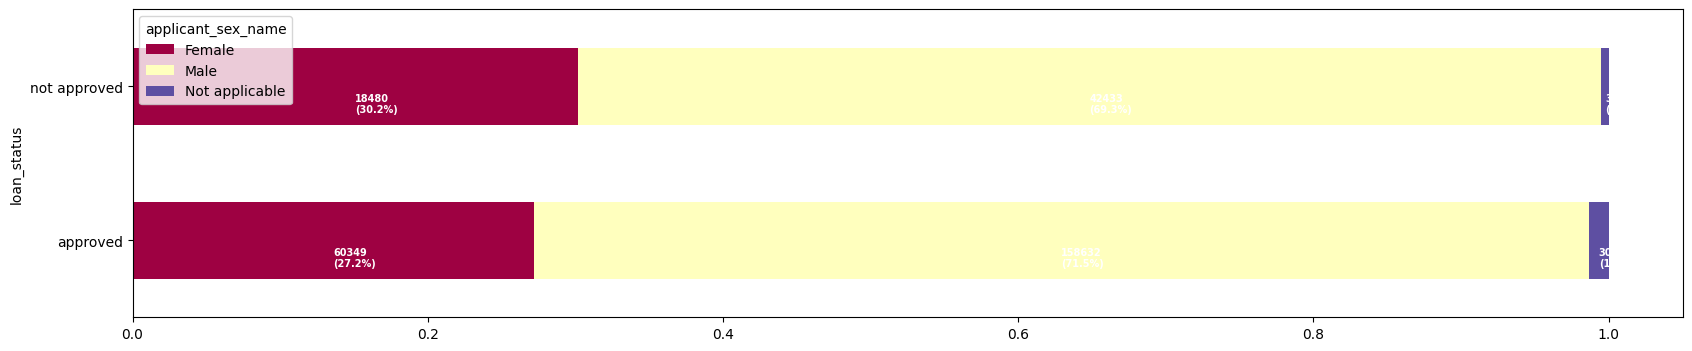

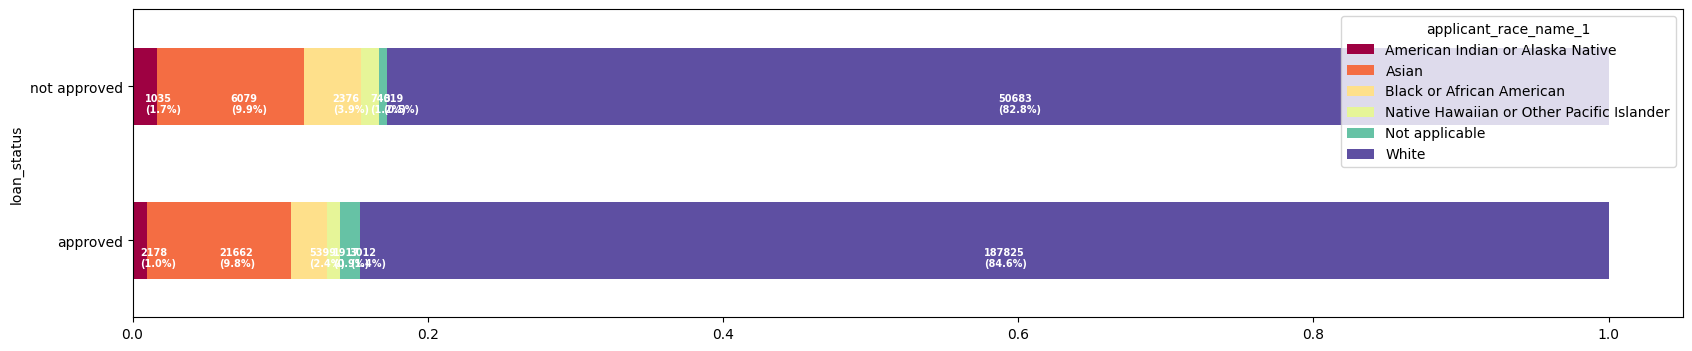

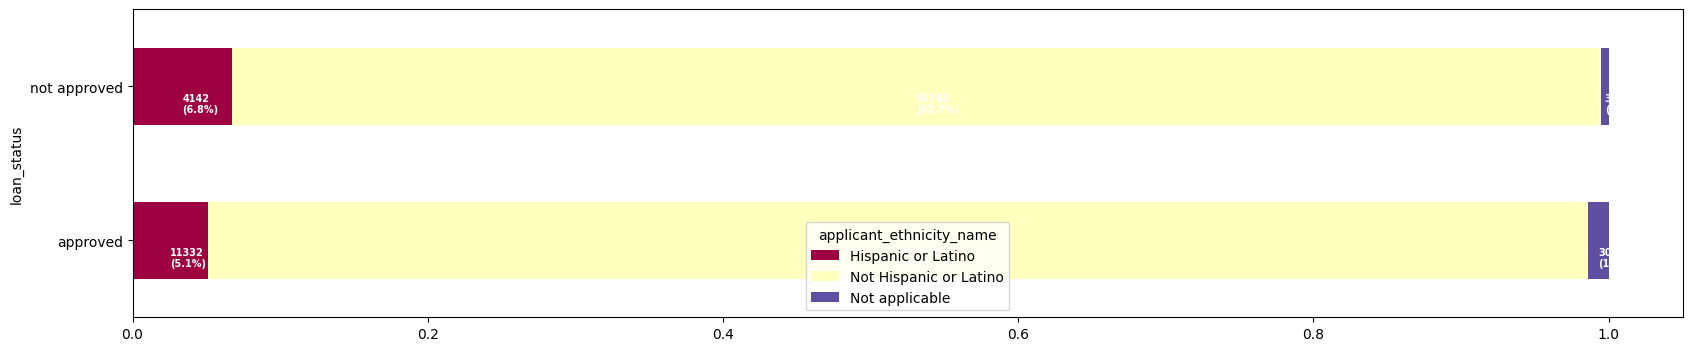

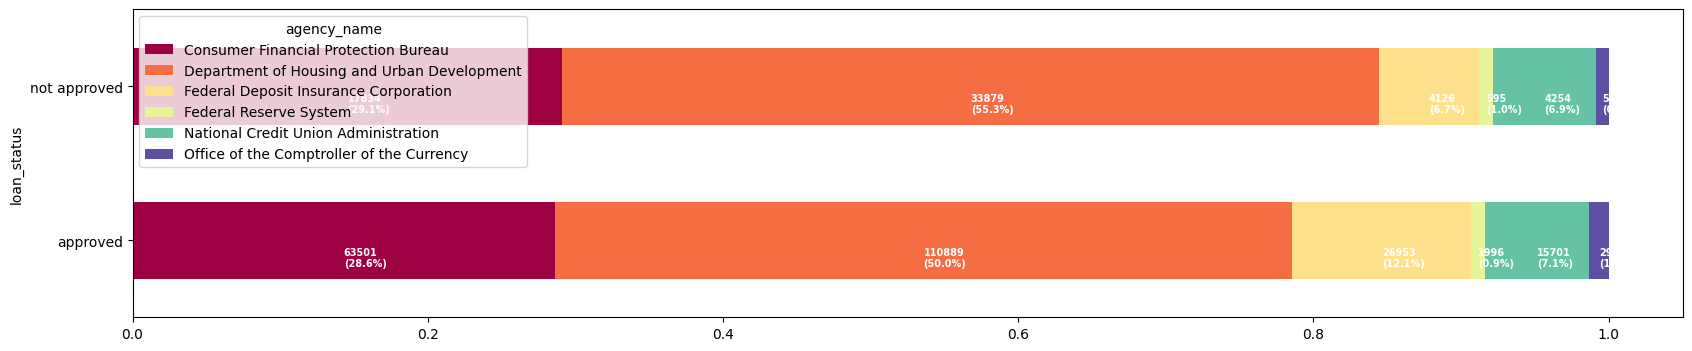

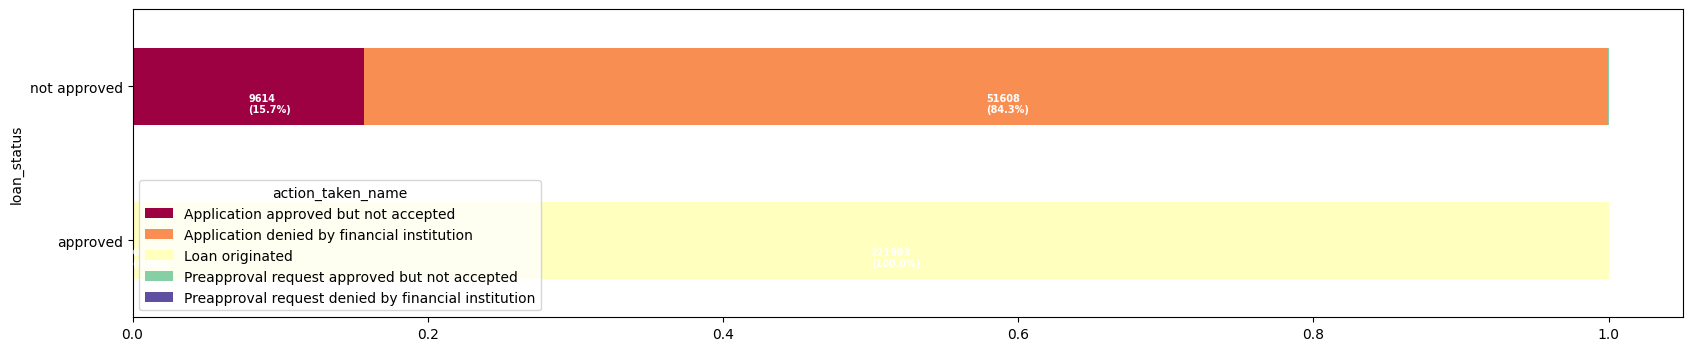

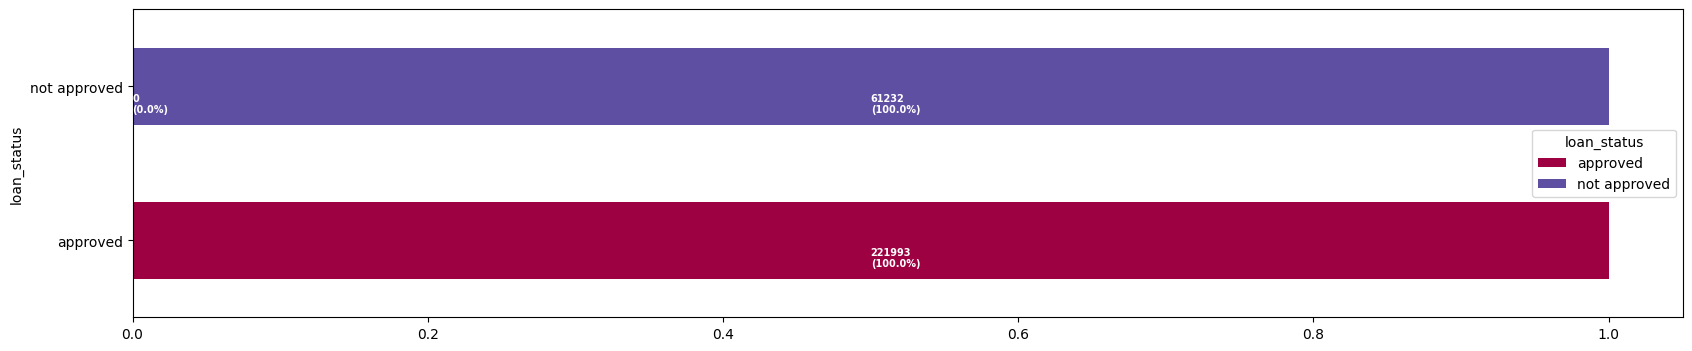

In [10]:
df_object = data.dtypes[data.dtypes=="object"]
col_object = df_object.index
for i in col_object:
        percent_stacked_bar(col = data[i],index =data['loan_status'],kind='barh',figsize=(20, 4))

**Reason For Denial**

In [11]:
data_loan_denial = data_original[['denial_reason_name_1','denial_reason_name_2','denial_reason_name_3']]

data_loan_denial = pd.DataFrame(pd.concat([data_loan_denial['denial_reason_name_1'],
                                         data_loan_denial['denial_reason_name_2'],
                                         data_loan_denial['denial_reason_name_3']],
                                         ignore_index=True).value_counts(normalize=True),
                                         columns=['denial_reason_count']) *100

data_loan_denial

,denial_reason_count
Debt-to-income ratio,23.303758
Credit history,21.686945
Collateral,15.045539
Credit application incomplete,14.553670
Other,13.668777
Unverifiable information,4.817491
"Insufficient cash (downpayment, closing costs)",4.704526
Employment history,2.082794
Mortgage insurance denied,0.136499


- The denial_reason_name_1,denial_reason_name_2 and denial_reason_name_3 columns contain the various reason why an applicant loan application is denied. Each applicant has atmost three reasons to be denied of a loan.  
**NB** :There is a huge number of missing data: a total of 42491 out of 1031065 is missing accross the three columns. Decision about it would be made a the Feature engineering section.
- Since we want the overall reasons that cuts accross all the three columns,the three features would be joined together into one column.  
- After that we find the percentage of each reason compared to the others.  
- From the graph below, the significant reason why applicants are denied of loans is Debt-to-income ratio and bad Credit History having  23% and 22% respectively.

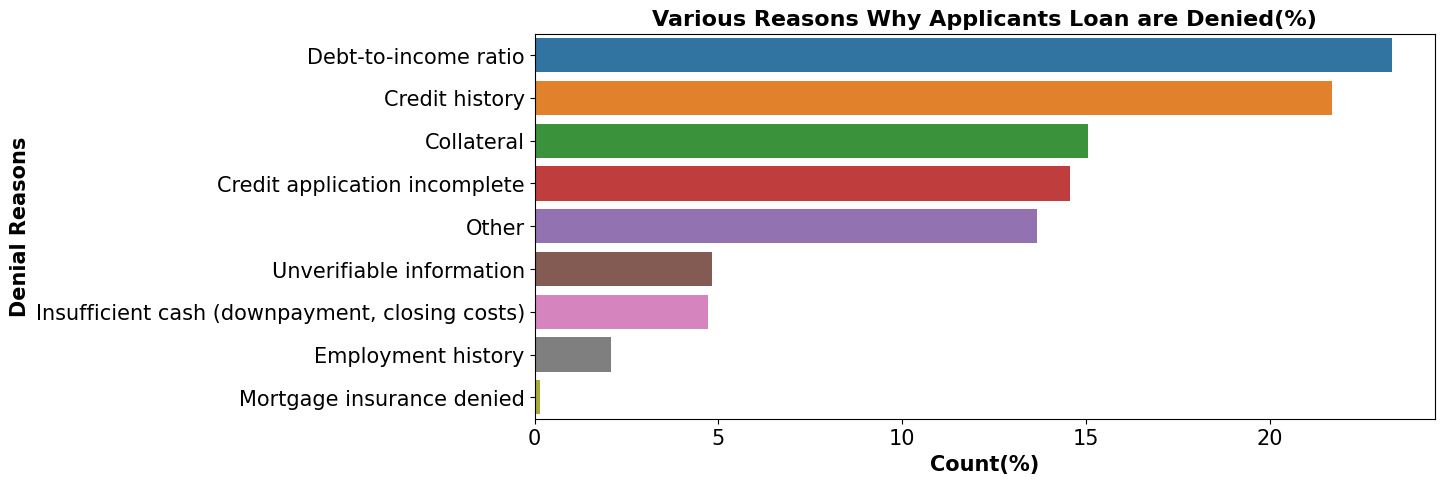

In [12]:
fig,ax  = plt.subplots(figsize=(15,5))

sns.barplot(y=data_loan_denial.index,x=data_loan_denial.denial_reason_count,orient='h')

plt.ylabel('Denial Reasons',fontdict={'fontsize':15,'fontweight':'bold'})

plt.xlabel('Count(%)',fontdict={'fontsize':15,'fontweight':'bold'})

plt.tick_params(axis='both',labelsize=15)

plt.subplots_adjust(left=0.3)

plt.title('Various Reasons Why Applicants Loan are Denied(%)',
          fontdict={'fontsize':16,'fontweight':'bold'});

### Does applicants gross income play role in his/her loan attainment?

- It shows clearly that debt-to-income ratio is the main reason why applicants are denied of loans. This brings up the question, is high income applicants having an edge over the lower income groups?